# 三、时间序列上的预测


In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 数据预处理
data = pd.read_csv("weatherHistory.csv")

data["Formatted Date"] = pd.to_datetime(data["Formatted Date"])
data.set_index("Formatted Date", inplace=True)

data["Year"] = data.index.year
data["Month"] = data.index.month
data["Day"] = data.index.day
data["Hour"] = data.index.hour

data = pd.get_dummies(data, columns=["Summary", "Precip Type"])

# **删除非数值型列**
data.drop(columns=['Daily Summary'], inplace=True)

# 数据集划分
train = data.loc[:"2016-12-31"]
test = data.loc["2017-01-01":]

# 特征缩放
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


### 使用ARIMA模型

由于ARIMA模型主要用于单变量时间序列数据，您可以选择Temperature (C)列进行建模。

C:\Users\18154\AppData\Local\Temp\ipykernel_20488\1044687529.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.asfreq('H')


Length of test_temperature: 19287
Shape of y_true: (24,)
Shape of y_pred: (24,)
ARIMA model RMSE: 4.642457203508018


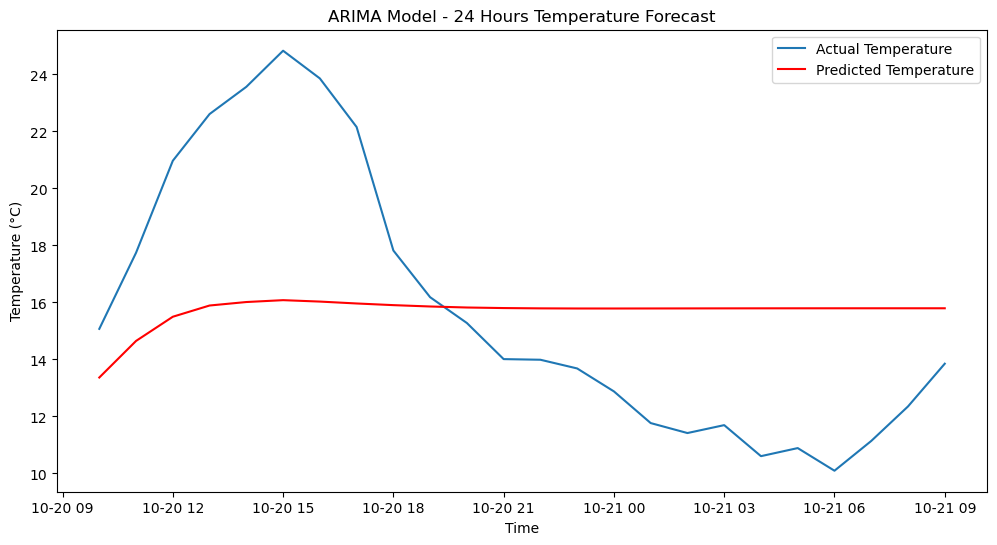

In [9]:
# 数据预处理
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

data = pd.read_csv("weatherHistory.csv")

data["Formatted Date"] = pd.to_datetime(data["Formatted Date"])
data.set_index("Formatted Date", inplace=True)

# 设置时间索引的频率
data = data.asfreq('H')

data["Year"] = data.index.year
data["Month"] = data.index.month
data["Day"] = data.index.day
data["Hour"] = data.index.hour

data = pd.get_dummies(data, columns=["Summary", "Precip Type"])
data.drop(columns=['Daily Summary'], inplace=True)

# 数据集划分（调整划分方式以确保测试集有足够的数据）
split_point = int(len(data) * 0.8)
train = data.iloc[:split_point]
test = data.iloc[split_point:]

# 提取温度数据
train_temperature = train['Temperature (C)']
test_temperature = test['Temperature (C)']

# 检查测试集长度
print(f"Length of test_temperature: {len(test_temperature)}")

# 建立ARIMA模型
model = ARIMA(train_temperature, order=(5,1,0))
model_fit = model.fit()

# 预测未来24小时
forecast = model_fit.forecast(steps=24)

# 获取真实值和预测值
y_true = test_temperature.iloc[:24].values
y_pred = forecast.values

# 检查形状
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# 计算均方误差
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'ARIMA model RMSE: {rmse}')

# 绘制预测结果
plt.figure(figsize=(12,6))
plt.plot(test_temperature.index[:24], y_true, label='Actual Temperature')
plt.plot(test_temperature.index[:24], y_pred, label='Predicted Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('ARIMA Model - 24 Hours Temperature Forecast')
plt.legend()
plt.show()


成功生成了ARIMA模型的预测结果和相应的图表，且预测的均方根误差（RMSE）为 4.64。从图中可以看到，模型预测的温度（红色线）相对平稳，而实际温度（蓝色线）有较大的波动。



SARIMA model RMSE: 3.5695041571623998


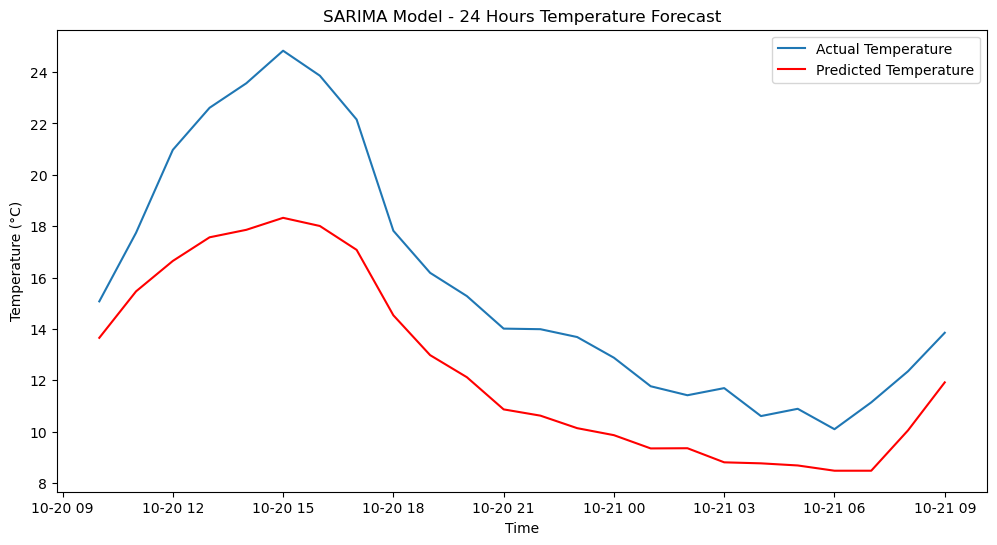

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 定义季节性周期长度，比如一天24小时
season_length = 24

# 建立SARIMA模型
model = SARIMAX(train_temperature, order=(5, 1, 0), seasonal_order=(1, 1, 1, season_length))
model_fit = model.fit()

# 预测未来24小时
forecast = model_fit.forecast(steps=24)

# 获取真实值和预测值
y_true = test_temperature.iloc[:24].values
y_pred = forecast.values

# 计算均方误差
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'SARIMA model RMSE: {rmse}')

# 绘制预测结果
plt.figure(figsize=(12,6))
plt.plot(test_temperature.index[:24], y_true, label='Actual Temperature')
plt.plot(test_temperature.index[:24], y_pred, label='Predicted Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('SARIMA Model - 24 Hours Temperature Forecast')
plt.legend()
plt.show()


### Prophet模型
Facebook的Prophet模型是另一个可以捕捉时间序列中的周期性和趋势变化的强大工具。它支持自定义的周期性，并且对处理有周期性和节假日效应的数据特别有效。

In [ ]:
# 导入必要的库
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np


# 然后在导入 Prophet 之前，设置 Prophet 使用 cmdstanpy 后端：
from prophet import Prophet
import cmdstanpy


# 安装 CmdStan（默认会进行编译）
cmdstanpy.install_cmdstan()

# 使用 Prophet 模型
model = Prophet(stan_backend="CMDSTANPY")

# 数据预处理
data = pd.read_csv("weatherHistory.csv", encoding='utf-8')

# 格式化日期
data["Formatted Date"] = pd.to_datetime(data["Formatted Date"])

# Prophet 要求数据有特定格式，列名必须是 'ds' 和 'y'
df_prophet = data[['Formatted Date', 'Temperature (C)']].rename(columns={'Formatted Date': 'ds', 'Temperature (C)': 'y'})

# 将训练集划分为训练数据和测试数据
train = df_prophet.loc[df_prophet['ds'] <= '2016-12-31']
test = df_prophet.loc[df_prophet['ds'] > '2016-12-31']

# 创建并拟合 Prophet 模型
model = Prophet()
model.fit(train)

# 进行未来24小时的预测
future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)

# 获取测试集的实际温度值
y_true = test['y'].iloc[:24].values

# 获取预测的温度值
y_pred = forecast['yhat'].iloc[-24:].values

# 计算均方误差 (MSE) 和根均方误差 (RMSE)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'Prophet模型的RMSE: {rmse}')

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(test['ds'].iloc[:24], y_true, label='实际温度')
plt.plot(test['ds'].iloc[:24], y_pred, label='预测温度', color='red')
plt.xlabel('时间')
plt.ylabel('温度 (°C)')
plt.title('Prophet 模型 - 24 小时温度预测')
plt.legend()
plt.show()


CmdStan install directory: C:\Users\18154\.cmdstan
Installing CmdStan version: 2.35.0
Download successful, file: C:\Users\18154\AppData\Local\Temp\tmpdodip50x
Extracting distribution


18:08:33 - cmdstanpy - WARNING - CmdStan installation failed.
Command "make build" failed
Command: ['mingw32-make', 'build', '-j1']
failed with error [WinError 2] 系统找不到指定的文件。



Unpacked download as cmdstan-2.35.0
Building version cmdstan-2.35.0, may take several minutes, depending on your system.


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd0 in position 0: invalid continuation byte

### 使用LSTM模型
对于LSTM模型，您需要确保输入数据是数值型的，并且调整输入形状。

Epoch 1/3


C:\Users\18154\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0700
Epoch 2/3
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0141
Epoch 3/3
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0137
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
训练集 RMSE: 1.0587270803653357
测试集 RMSE: 0.8398577177493427


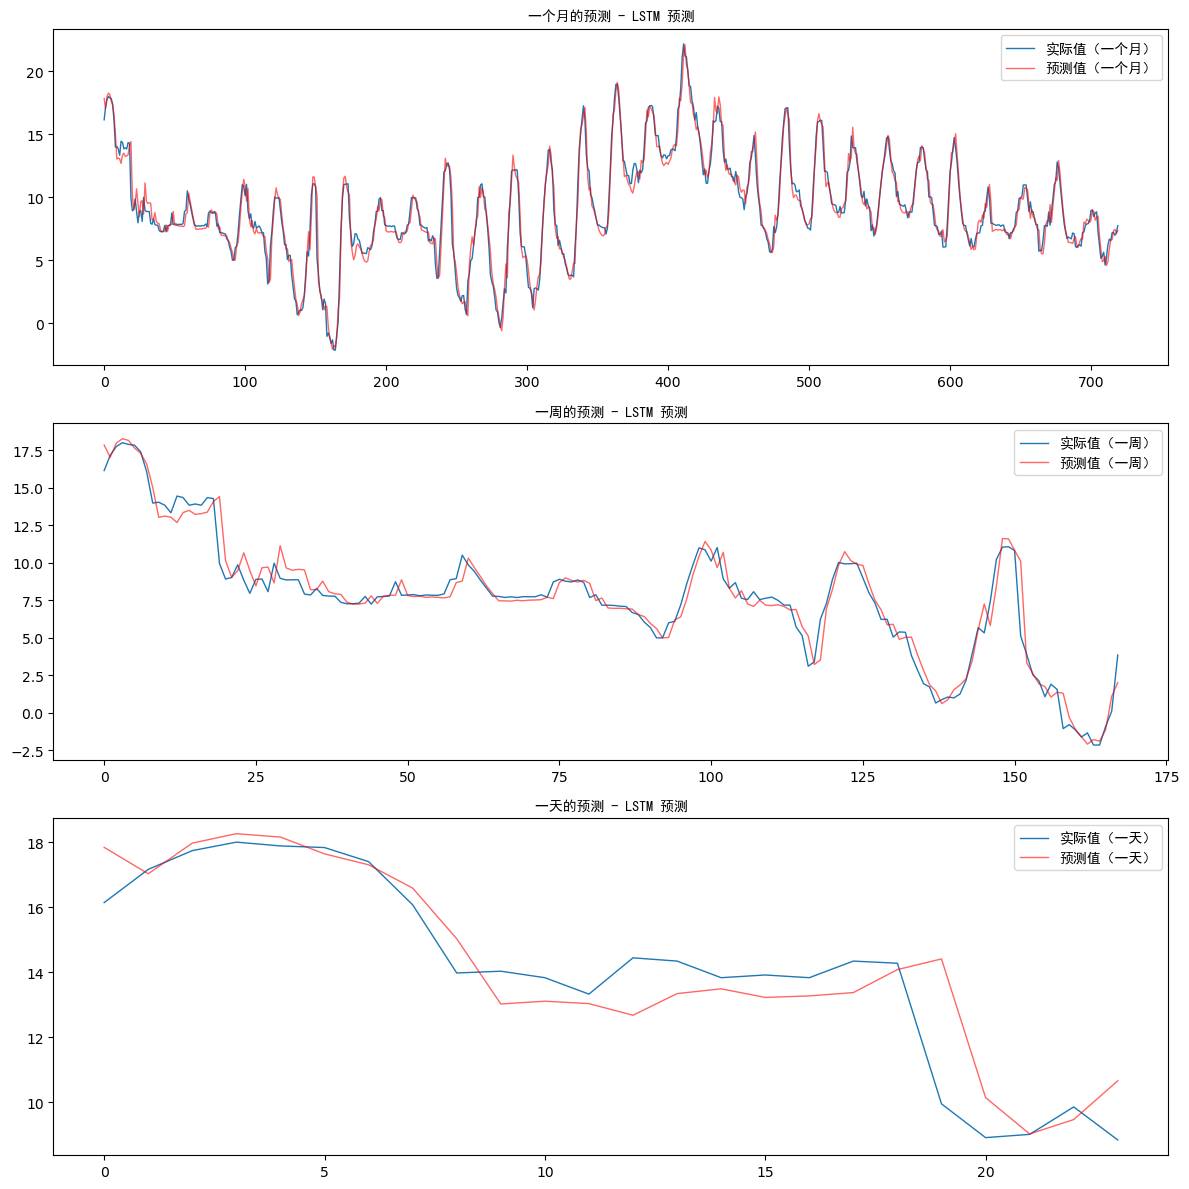

模型已保存到 lstm_model.h5


In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# 1. 数据预处理
data = pd.read_csv("weatherHistory.csv")

data["Formatted Date"] = pd.to_datetime(data["Formatted Date"])
data.set_index("Formatted Date", inplace=True)

# 选择需要的特征和目标变量，假设温度为预测目标
data = data[['Temperature (C)']]

# 缺失值处理
data.dropna(inplace=True)

# 2. 标准化数据
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 3. 创建监督学习格式的数据集
def create_dataset(data, time_step=24):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# 定义时间步长（比如 24小时作为一个时间步长）
time_step = 24

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# 构造 LSTM 所需的数据集格式
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 调整数据为 LSTM 需要的三维格式 [样本数, 时间步数, 特征数]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 4. 构建 LSTM 模型，增加层数和神经元数量
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))  # 第一层 LSTM
model.add(LSTM(100, return_sequences=False))  # 第二层 LSTM
model.add(Dense(50))  # 全连接层
model.add(Dense(1))   # 输出层

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. 增加训练轮数，重新训练模型
model.fit(X_train, y_train, batch_size=64, epochs=3)  # 增加训练轮数

# 6. 模型预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反标准化预测结果和真实数据
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# 计算 RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict[:, 0]))
print(f"训练集 RMSE: {train_rmse}")
print(f"测试集 RMSE: {test_rmse}")

# 7. 可视化结果 - 不同时间段的展示

# 选择测试集中的某一部分数据进行可视化
# 假设一天有24个时间点，一个月大约是720个时间点（24 * 30），一周是168个时间点（24 * 7）

# 定义各个时间段的长度
day_length = 24
week_length = 24 * 7
month_length = 24 * 30

plt.figure(figsize=(12, 12))

# 可视化一个月的数据
plt.subplot(3, 1, 1)
plt.plot(y_test_actual[0][:month_length], label='实际值（一个月）', linewidth=1)
plt.plot(test_predict[:, 0][:month_length], label='预测值（一个月）', color='red', linewidth=1, alpha=0.6)
plt.title('一个月的预测 - LSTM 预测', fontproperties='SimHei')
plt.legend(prop={'family': 'SimHei'})

# 可视化一周的数据
plt.subplot(3, 1, 2)
plt.plot(y_test_actual[0][:week_length], label='实际值（一周）', linewidth=1)
plt.plot(test_predict[:, 0][:week_length], label='预测值（一周）', color='red', linewidth=1, alpha=0.6)
plt.title('一周的预测 - LSTM 预测', fontproperties='SimHei')
plt.legend(prop={'family': 'SimHei'})

# 可视化一天的数据
plt.subplot(3, 1, 3)
plt.plot(y_test_actual[0][:day_length], label='实际值（一天）', linewidth=1)
plt.plot(test_predict[:, 0][:day_length], label='预测值（一天）', color='red', linewidth=1, alpha=0.6)
plt.title('一天的预测 - LSTM 预测', fontproperties='SimHei')
plt.legend(prop={'family': 'SimHei'})

plt.tight_layout()
plt.show()




In [5]:
# 保存数据

# 保存测试数据
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
print("测试数据已保存为 X_test.npy 和 y_test.npy")

# 6. 保存训练好的模型
model_path = 'lstm_model.h5'
model.save(model_path)
print(f"模型已保存到 {model_path}")



测试数据已保存为 X_test.npy 和 y_test.npy
模型已保存到 lstm_model.h5


### 滚动预测
之前实现的功能只有对于短时间内的预测，效果当然比较好，后面需要解决对于长时间序列下(一天、一周、一个月)的预测

C:\Users\18154\AppData\Local\Temp\ipykernel_3440\1598924650.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[0, -1, 0] = pred  # 将最后一个时间步更新为预测值


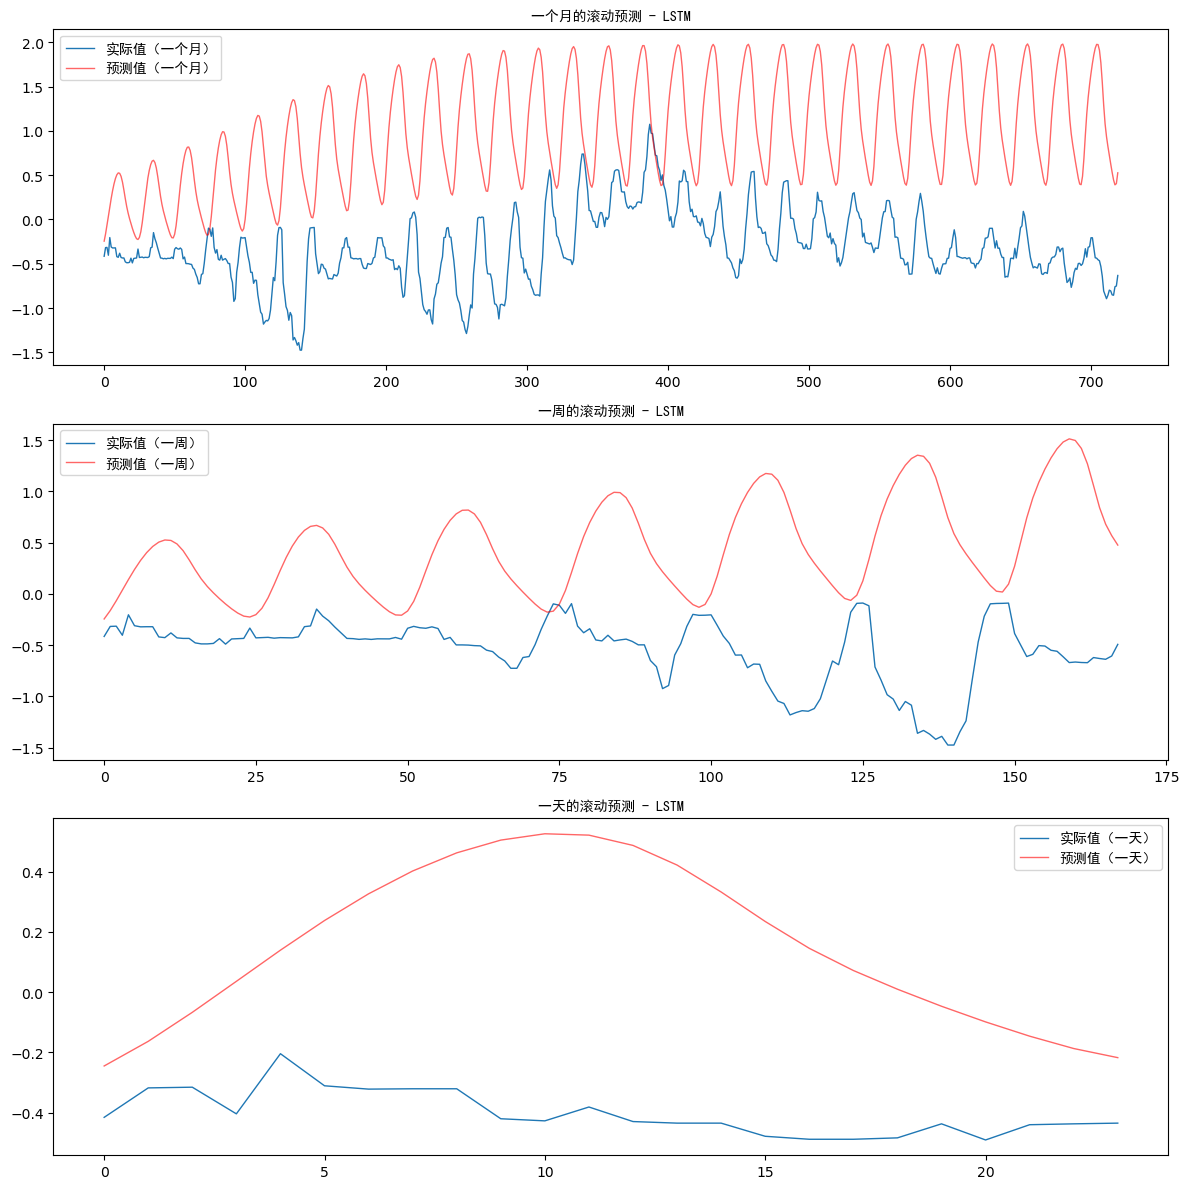

In [5]:
# 定义滚动预测函数
def recursive_forecast(model, input_data, steps):
    predictions = []
    current_input = input_data
    
    for _ in range(steps):
        # 预测下一个时间步
        pred = model.predict(current_input, verbose=0)
        
        # 将预测值保存
        predictions.append(pred[0, 0])
        
        # 使用当前预测值更新输入
        current_input = np.roll(current_input, -1)
        current_input[0, -1, 0] = pred  # 将最后一个时间步更新为预测值

    return np.array(predictions)

# 定义各个时间段的长度
day_length = 24  # 一天的步数
week_length = 24 * 7  # 一周的步数
month_length = 24 * 30  # 一个月的步数

# 初始输入为测试集中某一段
start_index = time_step  # 确保从第一个有效输入开始
initial_input = X_test[start_index].reshape(1, time_step, 1)

# 真实值应该从 start_index 对应的点开始
y_test_actual_segment = y_test[start_index:]

# 预测并展示一个月的数据
month_predict = recursive_forecast(model, initial_input, month_length)
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(y_test_actual_segment[:month_length], label='实际值（一个月）', linewidth=1)
plt.plot(month_predict, label='预测值（一个月）', color='red', linewidth=1, alpha=0.6)
plt.title('一个月的滚动预测 - LSTM', fontproperties='SimHei')
plt.legend(prop={'family': 'SimHei'})

# 预测并展示一周的数据
week_predict = recursive_forecast(model, initial_input, week_length)
plt.subplot(3, 1, 2)
plt.plot(y_test_actual_segment[:week_length], label='实际值（一周）', linewidth=1)
plt.plot(week_predict, label='预测值（一周）', color='red', linewidth=1, alpha=0.6)
plt.title('一周的滚动预测 - LSTM', fontproperties='SimHei')
plt.legend(prop={'family': 'SimHei'})

# 预测并展示一天的数据
day_predict = recursive_forecast(model, initial_input, day_length)
plt.subplot(3, 1, 3)
plt.plot(y_test_actual_segment[:day_length], label='实际值（一天）', linewidth=1)
plt.plot(day_predict, label='预测值（一天）', color='red', linewidth=1, alpha=0.6)
plt.title('一天的滚动预测 - LSTM', fontproperties='SimHei')
plt.legend(prop={'family': 'SimHei'})

plt.tight_layout()
plt.show() 

In [1]:
# predict.py

import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import matplotlib.pyplot as plt
import sys

# 配置 Matplotlib 以支持中文字体
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 使用 SimHei 字体显示中文
plt.rcParams["axes.unicode_minus"] = False  # 正确显示负号


# 定义滚动预测函数
def recursive_forecast(model_path, input_data, steps):
    """
    使用保存的模型进行滚动预测。
    """
    # 加载模型
    model = load_model(model_path)

    predictions = []
    current_input = input_data.copy()

    for _ in range(steps):
        # 预测下一个时间步
        pred = model.predict(current_input, verbose=0)

        # 将预测值保存
        predictions.append(pred[0, 0])

        # 使用当前预测值更新输入
        current_input = np.roll(current_input, -1)
        current_input[0, -1, 0] = pred

    return np.array(predictions)


# 定义处理每个起始点的函数
def process_starting_point(args):
    """
    处理单个起始点的预测任务。
    """
    (model_path, start_index, X_test, y_test, time_step, day_length, week_length) = args

    initial_input = X_test[start_index].reshape(1, time_step, 1)
    y_test_actual_segment = y_test[start_index:]

    # 预测一天的数据
    day_predict = recursive_forecast(model_path, initial_input, day_length)
    day_actual = y_test_actual_segment[:day_length]
    day_error = mean_squared_error(day_actual, day_predict)

    # 预测一周的数据
    week_predict = recursive_forecast(model_path, initial_input, week_length)
    week_actual = y_test_actual_segment[:week_length]
    week_error = mean_squared_error(week_actual, week_predict)

    return {
        "start_index": start_index,
        "day_error": day_error,
        "day_predict": day_predict,
        "day_actual": day_actual,
        "week_error": week_error,
        "week_predict": week_predict,
        "week_actual": week_actual,
    }


# 定义选择多个起始索引的函数
def select_start_indices(total_length, N, time_step, max_steps):
    """
    选择多个起始索引，确保每个起始点后有足够的步数进行预测。
    """
    available_length = total_length - time_step - max_steps
    if available_length <= 0:
        raise ValueError("测试集长度不足以进行所需的预测步数。")
    start_indices = np.linspace(time_step, available_length, N).astype(int)
    return start_indices


# 定义多进程预测函数
def run_multiprocessing(
    model_path, start_indices, X_test, y_test, time_step, day_length, week_length
):
    """
    使用多进程进行预测，并返回所有结果。
    """
    # 准备参数列表
    args_list = [
        (model_path, idx, X_test, y_test, time_step, day_length, week_length)
        for idx in start_indices
    ]

    # 获取 CPU 核心数量
    cpu_count = multiprocessing.cpu_count()
    print(f"使用 {cpu_count} 个进程进行预测...")

    # 使用 ProcessPoolExecutor 进行多进程预测
    with ProcessPoolExecutor(max_workers=cpu_count) as executor:
        results = list(executor.map(process_starting_point, args_list))

    return results


# 主函数
def main():
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    # 数据预处理和模型训练部分（假设之前已经完成并保存了模型）
    # 如果需要重新训练模型，可以在这里添加代码

    # 加载测试数据（假设在运行该脚本前已经处理好）
    # 这里假设 X_test 和 y_test 已经保存为 .npy 文件
    # 你需要根据实际情况调整数据加载方式

    # 示例：加载已处理好的测试数据
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    time_step = 24
    day_length = 24
    week_length = 24 * 7
    N = 100  # 选择100个起始点

    # 选择多个起始索引
    start_indices = select_start_indices(len(X_test), N, time_step, week_length)
    print(f"选择的起始索引: {start_indices}")

    # 模型保存路径
    model_path = "lstm_model.h5"

    # 运行多进程预测
    results = run_multiprocessing(
        model_path, start_indices, X_test, y_test, time_step, day_length, week_length
    )
    print("多进程预测完成！")

    # 从结果中选取一天和一周预测误差最小的
    best_day_result = min(results, key=lambda x: x["day_error"])
    best_week_result = min(results, key=lambda x: x["week_error"])

    print(
        f"最佳一天预测起始索引: {best_day_result['start_index']} - RMSE: {best_day_result['day_error']:.4f}"
    )
    print(
        f"最佳一周预测起始索引: {best_week_result['start_index']} - RMSE: {best_week_result['week_error']:.4f}"
    )

    # 可视化最佳预测结果
    plt.figure(figsize=(14, 10))

    # 可视化最佳一天的预测结果
    plt.subplot(2, 1, 1)
    plt.plot(best_day_result["day_actual"], label="实际值（一天）", linewidth=1)
    plt.plot(
        best_day_result["day_predict"],
        label="预测值（一天）",
        color="red",
        linewidth=1,
        alpha=0.6,
    )
    plt.title(
        f'一天的滚动预测 - 最佳结果 (起始索引: {best_day_result["start_index"]}) - RMSE: {best_day_result["day_error"]:.4f}'
    )
    plt.legend(prop={"family": "SimHei"})

    # 可视化最佳一周的预测结果
    plt.subplot(2, 1, 2)
    plt.plot(best_week_result["week_actual"], label="实际值（一周）", linewidth=1)
    plt.plot(
        best_week_result["week_predict"],
        label="预测值（一周）",
        color="red",
        linewidth=1,
        alpha=0.6,
    )
    plt.title(
        f'一周的滚动预测 - 最佳结果 (起始索引: {best_week_result["start_index"]}) - RMSE: {best_week_result["week_error"]:.4f}'
    )
    plt.legend(prop={"family": "SimHei"})

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


选择的起始索引: [   24   216   408   601   793   985  1178  1370  1562  1755  1947  2140
  2332  2524  2717  2909  3101  3294  3486  3679  3871  4063  4256  4448
  4640  4833  5025  5218  5410  5602  5795  5987  6179  6372  6564  6757
  6949  7141  7334  7526  7718  7911  8103  8296  8488  8680  8873  9065
  9257  9450  9642  9835 10027 10219 10412 10604 10796 10989 11181 11374
 11566 11758 11951 12143 12335 12528 12720 12913 13105 13297 13490 13682
 13874 14067 14259 14452 14644 14836 15029 15221 15413 15606 15798 15991
 16183 16375 16568 16760 16952 17145 17337 17530 17722 17914 18107 18299
 18491 18684 18876 19069]
使用 20 个进程进行预测...


BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

Jupyter内核跑多线程适配有点问题，实际跑的情况在[Python文件](forcast-LSTM.py)中跑了能看效果。
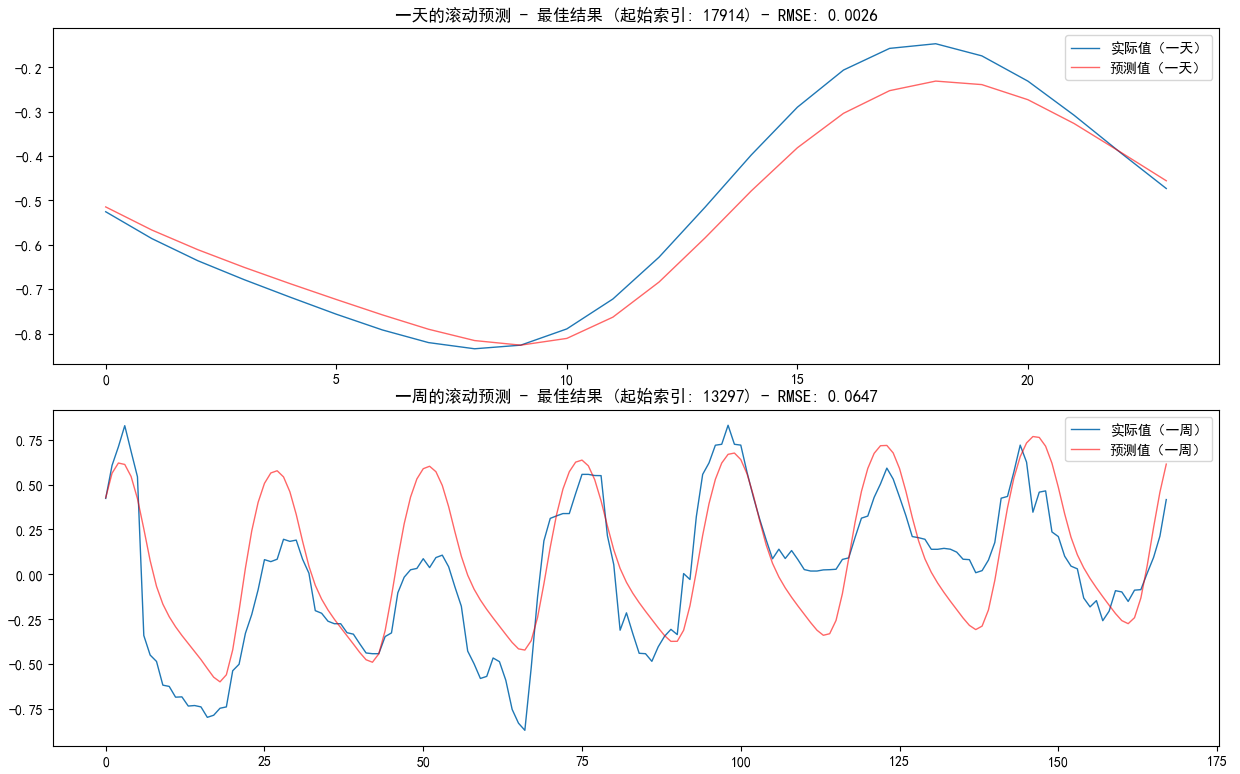

In [ ]:
为了展现模拟能力与预测时间长度的关系，下面代码计算了不同预测时间长度下的RSME的关系。

In [ ]:
# predict_with_variance_plot.py

import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import matplotlib.pyplot as plt
import sys
import random

# 配置 Matplotlib 以支持中文字体
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 使用 SimHei 字体显示中文
plt.rcParams["axes.unicode_minus"] = False  # 正确显示负号


# 定义滚动预测函数
def recursive_forecast(model_path, input_data, steps):
    """
    使用保存的模型进行滚动预测。
    """
    # 加载模型
    model = load_model(model_path)

    predictions = []
    current_input = input_data.copy()

    for _ in range(steps):
        # 预测下一个时间步
        pred = model.predict(current_input, verbose=0)

        # 将预测值保存
        predictions.append(pred[0, 0])

        # 使用当前预测值更新输入
        current_input = np.roll(current_input, -1)
        current_input[0, -1, 0] = pred

    return np.array(predictions)


# 定义处理每个起始点和预测长度的函数
def process_forecast(args):
    """
    处理单个起始点和预测长度的预测任务。
    """
    (model_path, start_index, X_test, y_test, time_step, pred_length) = args

    initial_input = X_test[start_index].reshape(1, time_step, 1)
    y_test_actual_segment = y_test[start_index : start_index + pred_length]

    if len(y_test_actual_segment) < pred_length:
        # 如果实际数据不足，返回高误差
        return {"pred_length": pred_length, "mse": float("inf")}

    # 进行递归预测
    pred = recursive_forecast(model_path, initial_input, pred_length)

    # 计算均方误差
    mse = mean_squared_error(y_test_actual_segment, pred)

    return {"pred_length": pred_length, "mse": mse}


# 定义选择多个随机起始索引的函数
def select_random_start_indices(total_length, N, time_step, max_steps):
    """
    随机选择多个起始索引，确保每个起始点后有足够的步数进行预测。
    """
    available_length = total_length - time_step - max_steps
    if available_length <= 0:
        raise ValueError("测试集长度不足以进行所需的预测步数。")

    # 随机选择 N 个起始点
    start_indices = random.sample(range(time_step, available_length), N)
    return start_indices


# 定义多进程预测函数
def run_multiprocessing_forecast(
    model_path, start_indices, X_test, y_test, time_step, pred_length
):
    """
    使用多进程进行预测，并返回所有结果。
    """
    # 准备参数列表
    args_list = [
        (model_path, idx, X_test, y_test, time_step, pred_length)
        for idx in start_indices
    ]

    # 获取 CPU 核心数量
    cpu_count = multiprocessing.cpu_count()
    print(f"使用 {cpu_count} 个进程进行预测...")

    # 使用 ProcessPoolExecutor 进行多进程预测
    with ProcessPoolExecutor(max_workers=cpu_count) as executor:
        results = list(executor.map(process_forecast, args_list))

    return results


# 定义计算不同预测长度下误差的函数
def compute_variance_over_time(
    model_path, X_test, y_test, time_step, N, max_pred_length
):
    """
    计算不同预测长度下预测误差的均值。
    """
    # 随机选择 N 个起始点
    start_indices = select_random_start_indices(
        len(X_test), N, time_step, max_pred_length
    )
    print(f"随机选择的起始索引: {start_indices}")

    # 获取所有预测长度
    pred_lengths = list(range(1, max_pred_length + 1))  # 1小时到72小时

    variance_means = []

    for pred_length in pred_lengths:
        print(f"计算预测长度: {pred_length} 小时")
        results = run_multiprocessing_forecast(
            model_path, start_indices, X_test, y_test, time_step, pred_length
        )
        # 过滤掉因数据不足返回的无穷大误差
        valid_results = [res["mse"] for res in results if res["mse"] != float("inf")]
        if valid_results:
            mean_mse = np.mean(valid_results)
        else:
            mean_mse = None  # 或者设为 np.nan
        variance_means.append(mean_mse)
        print(f"预测长度 {pred_length} 小时的平均MSE: {mean_mse}")

    return pred_lengths, variance_means


# 主函数
def main():
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    # 加载测试数据
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    time_step = 24  # 假设时间步为24小时
    N = 20  # 随机选择20个起始点
    max_pred_length = 48  # 最大预测长度为48小时（2天）

    # 模型保存路径
    model_path = "lstm_model.h5"

    # 计算不同预测长度下的平均MSE
    pred_lengths, variance_means = compute_variance_over_time(
        model_path, X_test, y_test, time_step, N, max_pred_length
    )
    print("不同预测长度下的平均MSE计算完成！")

    # 绘制预测长度与平均MSE的关系图
    plt.figure(figsize=(12, 6))
    plt.plot(pred_lengths, variance_means, marker="o", linestyle="-", color="b")
    plt.title("预测时间长度与预测误差方差均值关系图")
    plt.xlabel("预测时间长度（小时）")
    plt.ylabel("预测误差均值（MSE）")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


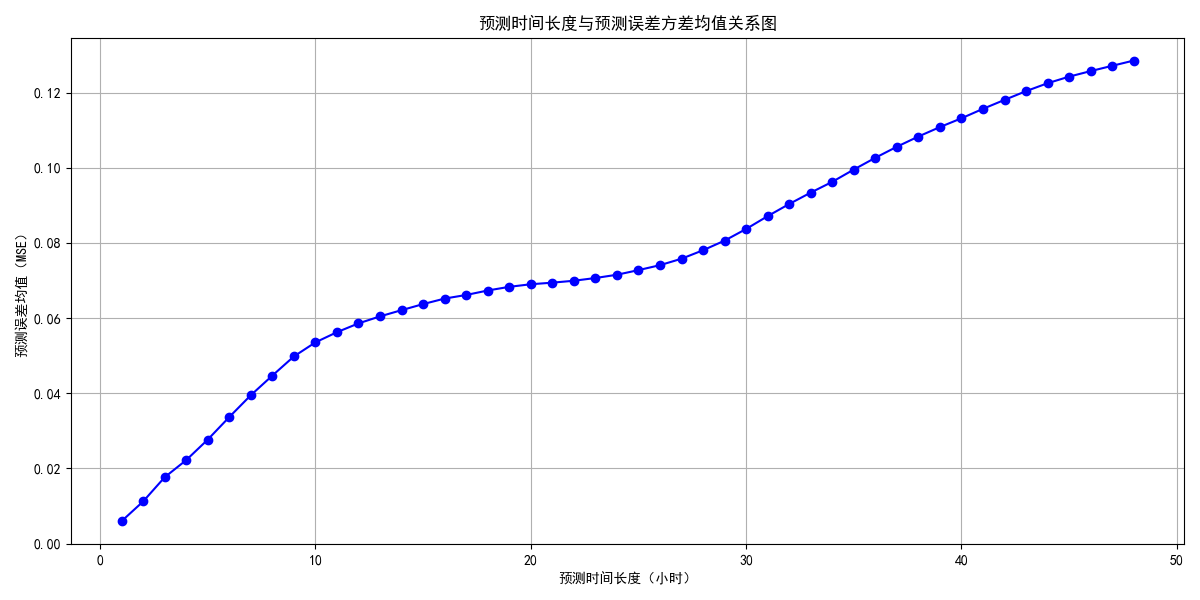
可以看到模型的能力会随着预测时间的增长而降低，但是当时间到1天/2天左右的时候能力又会有所回升。
可能的原因是相差两天相同时间的温度接近。

## 未来的优化方向

### 1. 贝叶斯优化

使用贝叶斯优化方法优化超参数，提高模型性能。


### 2. 使用双向LSTM

双向LSTM能够同时捕捉序列的前向和后向信息。


### 3. 引入注意力机制
注意力机制可以帮助模型关注序列中的重要部分。

## 特征重要性分析

### 1. 计算可视化SHAP值



已加载模型：lstm_model.h5
TensorFlow 版本: 2.17.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
已创建 SHAP KernelExplainer 解释器
选择了 3 个样本进行 SHAP 分析
正在计算 SHAP 值，请耐心等待（KernelExplainer 计算较慢）...


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step


 33%|███▎      | 1/3 [00:45<01:30, 45.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step


 67%|██████▋   | 2/3 [01:25<00:42, 42.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step


100%|██████████| 3/3 [02:05<00:00, 41.98s/it]


已计算 SHAP 值


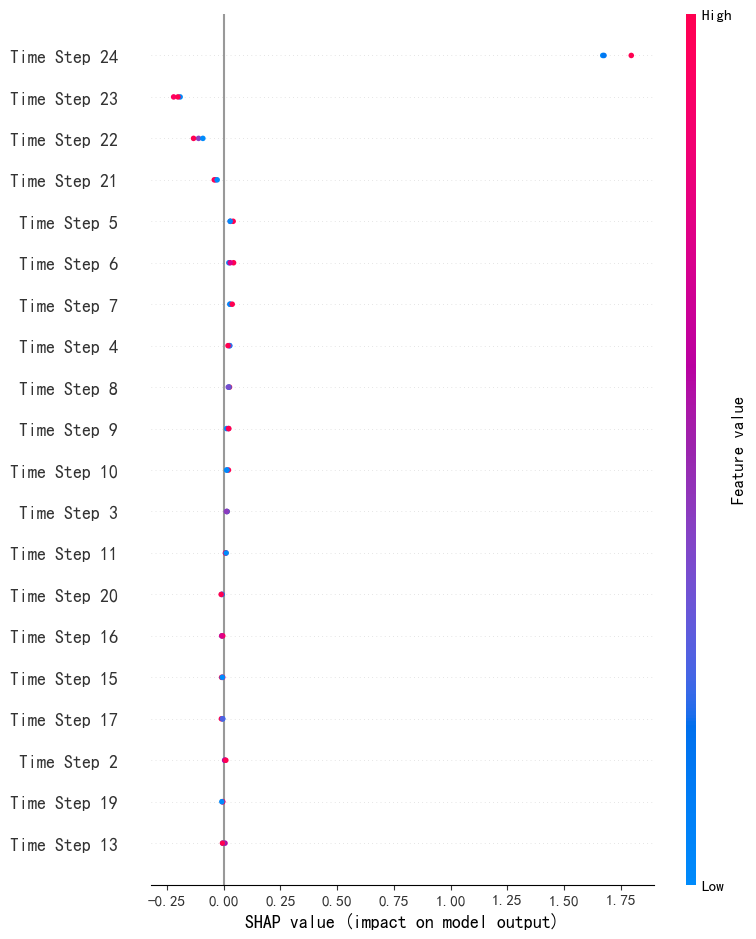

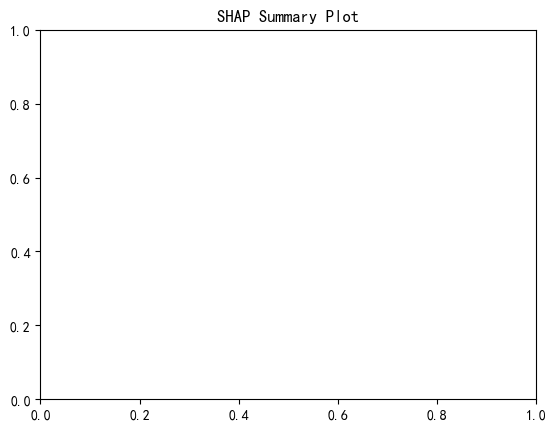

<Figure size 1000x500 with 0 Axes>

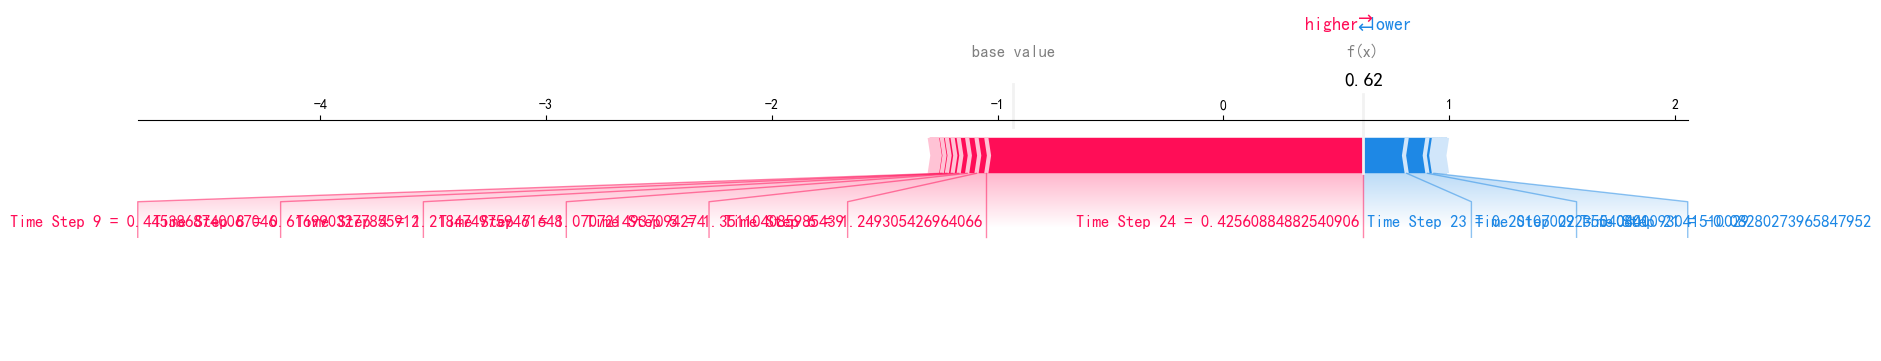

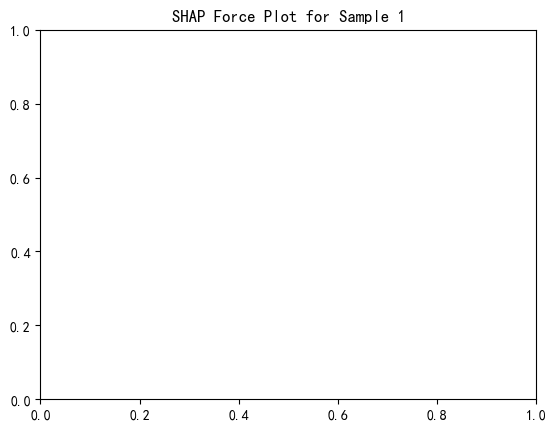

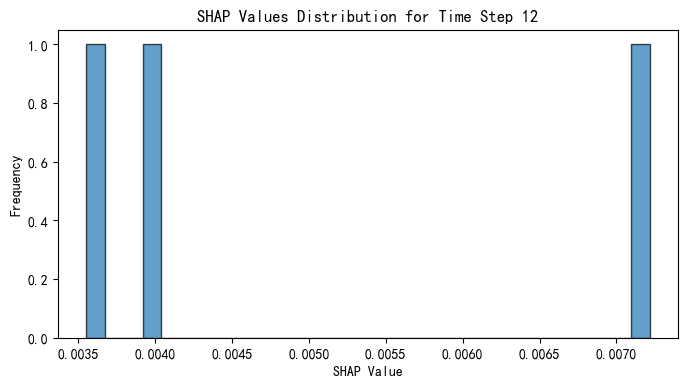

In [8]:
# SHAP 分析脚本

# 1. 导入必要的库
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import shap
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf

# 2. 数据预处理
# 读取数据
data = pd.read_csv("weatherHistory.csv")

# 解析日期并设置为索引
data["Formatted Date"] = pd.to_datetime(data["Formatted Date"])
data.set_index("Formatted Date", inplace=True)

# 选择温度作为目标变量
data = data[['Temperature (C)']]

# 处理缺失值
data.dropna(inplace=True)

# 标准化数据
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 创建监督学习格式的数据集
def create_dataset(data, time_step=24):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# 定义时间步长（24小时）
time_step = 24

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# 构造 LSTM 所需的数据集格式
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 调整数据为 LSTM 需要的三维格式 [样本数, 时间步数, 特征数]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. 加载已训练的 LSTM 模型
model_path = 'lstm_model.h5'
model = load_model(model_path)
print(f"已加载模型：{model_path}")

# 4. SHAP 分析

# 4.1. 检查 TensorFlow 版本
print(f"TensorFlow 版本: {tf.__version__}")

# 4.2. 准备背景数据
# 选择训练集的一部分作为背景数据
background = X_train[:100]  # 根据内存和计算资源调整样本数量

# 4.3. 创建 SHAP 解释器
# 由于 DeepExplainer 在 TensorFlow 2.17.0 下存在兼容性问题，使用 KernelExplainer
def model_predict(X):
    """
    定义一个预测函数，将 KernelExplainer 的输入（二维）转换为模型需要的三维格式
    """
    X = X.reshape(X.shape[0], time_step, 1)
    return model.predict(X).flatten()

# 使用 KernelExplainer 进行解释
explainer = shap.KernelExplainer(model_predict, background.reshape(background.shape[0], time_step))
print("已创建 SHAP KernelExplainer 解释器")

# 4.4. 选择要解释的样本
X_sample = X_test[:3]  # 根据需要调整样本数量
print(f"选择了 {X_sample.shape[0]} 个样本进行 SHAP 分析")

# 4.5. 计算 SHAP 值
print("正在计算 SHAP 值，请耐心等待（KernelExplainer 计算较慢）...")
shap_values = explainer.shap_values(X_sample.reshape(X_sample.shape[0], time_step))
print("已计算 SHAP 值")

# 4.6. 可视化 SHAP 结果

# 将数据重新塑形为 [样本数, 时间步数]
X_sample_reshaped = X_sample.reshape(X_sample.shape[0], time_step)

# 4.6.1. 可视化总体 SHAP 概述
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_sample_reshaped, feature_names=[f'Time Step {i+1}' for i in range(time_step)])
plt.title('SHAP Summary Plot')
plt.show()

# 4.6.2. 可视化单个样本的 SHAP 值（力导向图）
sample_index = 0  # 选择第一个样本
plt.figure(figsize=(10, 5))
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_index],
    X_sample_reshaped[sample_index],
    feature_names=[f'Time Step {i+1}' for i in range(time_step)],
    matplotlib=True
)
plt.title(f'SHAP Force Plot for Sample {sample_index + 1}')
plt.show()

# 4.6.3. 可视化特定时间步的 SHAP 值分布
time_step_index = 11  # 选择第 12 个时间步（0-based index）
shap_values_time_step = shap_values[:, time_step_index]

plt.figure(figsize=(8, 4))
plt.hist(shap_values_time_step, bins=30, edgecolor='k', alpha=0.7)
plt.title(f'SHAP Values Distribution for Time Step {time_step_index + 1}')
plt.xlabel('SHAP Value')
plt.ylabel('Frequency')
plt.show()
